# Intro to Autoencoders

This notebook introduces autoencoders in the context of image compression use case.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Load the dataset
To start, we will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


**To start**

This example defines an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.


In [ ]:
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 9s 3ms/step - loss: 0.0236 - val_loss: 0.0134
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0116 - val_loss: 0.0105
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.008

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

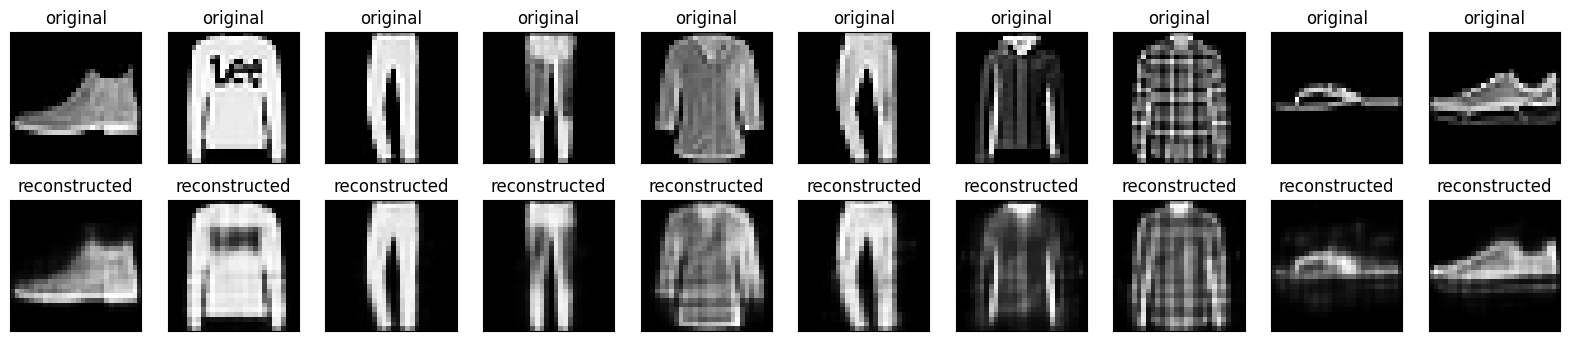

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

**STEP 1: The main steps in the code above to achieve image compression**

1. **Chargement du Jeu de Données :** Le jeu de données utilisé est le jeu de données Fashion MNIST, qui contient des images de 28x28 pixels. Une première étape de preprocessing est appliquée, à savoir la normalisation des valeurs des pixels des images.

2. **Définition du Modèle d'Autoencodeur :** Dans le but de compresser les images, un autoencoder à deux layers dense est ici utilisé. Son architecture peut-être décomposée en 2 parties clés:
   - **Encodeur :** Les images d'entrée (précédement normalisées) sont compressées dans un vecteur latent de dimension inférieur. Dans notre cas, l'image d'origine de taille initialle 28x28 est comprésée à l'intérieur d'un vecteur de taille 64. Le but est d'essayer de concerver le plus d'information possible de l'image d'origine dans un espace beaucoup plus petit.
   - **Décodeur :** A partir de l'espace latent de taille 64 et des informations qui y sont contenus, les images sont reconstruites en format 28x28 (et elles restent normalisée).

3. **Entraînement du Modèle :** Le modèle est entraîné en utilisant le jeu de données d'entraînement où les images d'entrée sont utilisées à la fois comme entrée et comme sortie cible. En effet, le but est d'apprendre le modèle à mieux structurer les informations de l'image d'origine dans le vecteur latent afin qu'il puisse reconstruire de mieux en mieux les images originales. Cela se fait en "pénalisant" plus les images mal reconstruites que celle mieux reconstruites (à l'aide de la loss: MeanSquaredError (MSE))

$$\text{MSE}(y, \hat{y}) = \frac{\sum_{i=0}^{N - 1} (y_i - \hat{y}_i)^2}{N}$$

 Evidemment, cette méthode de compression/décompression n'est pas parfait et implique donc de la perte, c'est à dire que les images reconstruites sont souvent un peu différentes visuellement de l'image d'origine.

5. **Test du Modèle :** Après l'entraînement, la performance du modèle est évaluée en encodant et décodant des images du jeu de test pour voir à quel point les images originales sont bien reconstruites.

**STEP 2: Checking the compression quality for every image of the previous figure. Let's measure it and define correlated metrics to the subjective perspective.**

Visuellement, les images reconstruites sont proches des images d'origine.On devine facilement l'image d'origine liée à l'image reconstruite mais on remarque tout de même une dégradation notable au niveau des détails. En effet, des inscriptions ou des patterns de couleurs sont floues.

Mis à part mon avis subjectif, il est difficile d'évaluer la qualité visuelle d'une image par rapport à une image d'origine de façon objective. Certains modèles du SVH sont utilisés pour prendre en compte la sensibilité aux fréquences, les masquages, etc... mais je ne vais pas ici en utiliserr.

Cependant, il est possible et plus facile de quantitativement (donc objectivement) mesurer la qualité de reconstruction d'une image par rapport à l'image d'origine notamment à l'aide de métriques telles que:

- L'erreur quadratique moyenne (Mean Squared Error - MSE) nous donne la moyenne des écarts quadratiques entre les deux images.

$$\text{MSE}(y, \hat{y}) = \frac{\sum_{i=0}^{N - 1} (y_i - \hat{y}_i)^2}{N}$$

- Le rapport signal-sur-bruit de crête (Peak Signal-to-Noise Ratio - PSNR) quantifie la différence entre les deux images.

$$MAX_I = 255$$
$$\text{PSNR} = 10 \cdot \log_{10} \left( \frac{MAX_I^2}{\text{MSE}} \right)$$

Calculons ces 2 métriques sur un batch d'echantillons:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse

# Function to calculate MSE
def calculate_mse(original, reconstructed):
    return mse(original, reconstructed) # Already done with numpy yeasterday

# Function to calculate PSNR
def calculate_psnr(original, reconstructed):
    return psnr(original, reconstructed) # Already done with numpy yeasterday

def plot_quantitative_analysis(x_test, decoded_imgs):
  plt.figure(figsize=(50, 10))
  for i in range(2):
      # Calculate MSE and PSNR for the current sample
      current_mse = calculate_mse(x_test[i], decoded_imgs[i])
      current_psnr = calculate_psnr(x_test[i], decoded_imgs[i])

      # Display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(x_test[i])
      plt.title("Original")
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded_imgs[i])
      plt.title(f"Reconstructed\nMSE: {current_mse:.4f}, PSNR: {current_psnr:.2f} dB")
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

  plt.show()
  plt.close()

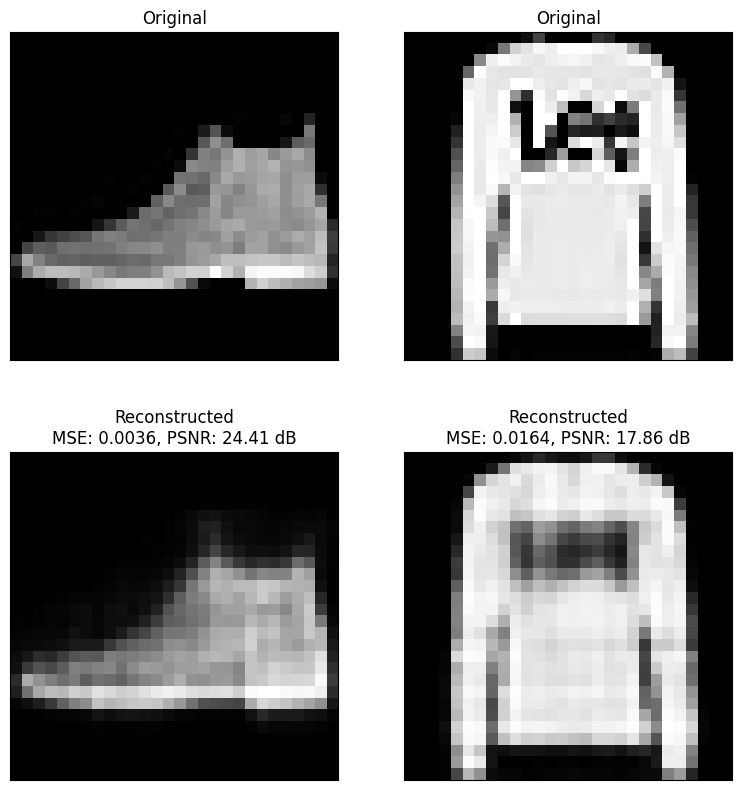

In [ ]:
plot_quantitative_analysis(x_test, decoded_imgs)

Comme nous pouvons le voir, il y a visuellement des différences, mais pour autant la MSE reste êtrèment faible identiquent que les images d'origine et reconstruites sont quantitativement très proches.

La PSNR elle n'est pas très élevée, signifiant donc que les artefacts introduits par la compression ou la reconstruction sont perceptibles pour l'oeil humain.

**STEP 3 : Let's implement a function to fine-tune the auto-encoder parameters and achieve acceptable compression performance**

Tout d'abord définissons une fonction permettant de cacluler le taux de compression (T) et regardons la valeurs de T pour le modèle par défaut.

In [ ]:
def get_compression_rate(encoded_imgs, decoded_imgs):
    return decoded_imgs[0].shape[0] * decoded_imgs[0].shape[1] / encoded_imgs[0].shape[0]

In [ ]:
compression_rate = get_compression_rate(encoded_imgs, decoded_imgs)

print("T1:", compression_rate)

T1: 12.25


Ici nous allons jouer avec les hyperparamètres pour essayer de trouver un modèle plus performant. Il serait plus judicieux de lancer un Grid Search ou Optuna sur les hyperparamètres pour trouver le meilleur modèle possible, cepandant par manque de temps nous allons simplement changer certains hyperparamètres à la main.

Dans le but d'obtenir de meilleur résultats j'ai augmenté le nombre d'époques pour l'entrainement de 10 à 50, augmenter le nombre d'images d'entrainement par batch ainsi qu'augmenté la taille du vecteur latent pour qu'il puisse retenir plus de détails de l'image originale.

In [ ]:
def fine_tune_autoencoder(encoding_dim=64, epochs=50, batch_size=64):
    autoencoder = Autoencoder(encoding_dim)
    autoencoder.compile(optimizer='adam', loss='mse')

    history = autoencoder.fit(x_train, x_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_data=(x_test, x_test))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    print(f'Final training loss: {loss[-1]}')
    print(f'Final validation loss: {val_loss[-1]}')

    return autoencoder, history

In [ ]:
autoencoder, history = fine_tune_autoencoder(encoding_dim=128, epochs=50, batch_size=256)

encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

Epoch 1/50
235/235 [==============================] - 2s 5ms/step - loss: 0.0443 - val_loss: 0.0231
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0186 - val_loss: 0.0155
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0136 - val_loss: 0.0124
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0094 - val_loss: 0.0091
Epoch 7/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 8/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 9/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0075 - val_loss: 0.0075

In [ ]:
compression_rate = get_compression_rate(encoded_imgs, decoded_imgs)
print("T_after_fine_tune:", compression_rate)

T_after_fine_tune: 6.125


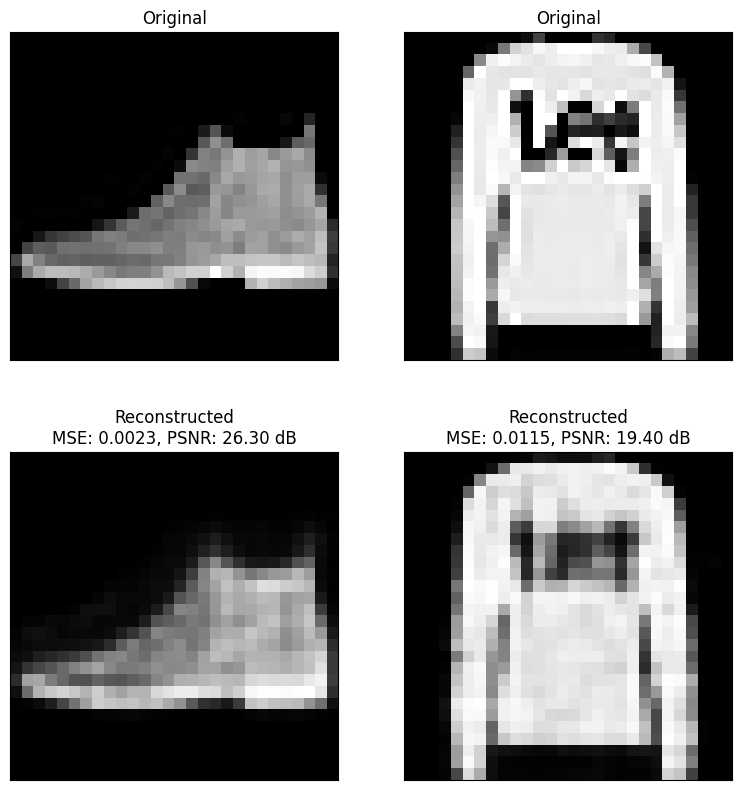

In [ ]:
plot_quantitative_analysis(x_test, decoded_imgs)

On remarque que la compression est quantitativement et visuellement meilleure. En effet, visuellement c'est plutot flagrant et quantitativement la MSE a diminué en général, et le PSNR a augmenté indiquant donc que la reconstruction est très proche de l'original et que les artefacts sont moins visibles.

Cependant, cela a un impact direct sur le taux de compression. En effet il est 2 fois moins élevé, passant de ~12 à ~6.

**STEP 4: Let's run compression on new aditionnal images and conclude about model architecture VS images types / resolution.**

In [ ]:
from PIL import Image

img_path = 'COCO_natural.jpeg'
img = Image.open(img_path).convert('L')
img = img.resize((28, 28))
img_array = np.array(img) / 255.0
img_array = img_array.reshape((1, 28, 28))

# Encode and decode the image using the autoencoder
encoded_img = autoencoder.encoder(img_array).numpy()
decoded_img = autoencoder.decoder(encoded_img).numpy()

(-0.5, 27.5, 27.5, -0.5)

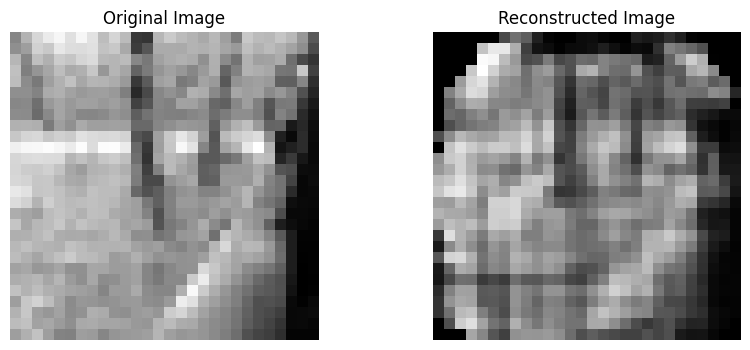

In [ ]:
# Display the original and reconstructed images
plt.figure(figsize=(10, 4))

# Display original image
ax = plt.subplot(1, 2, 1)
plt.imshow(img_array[0], cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Display reconstructed image
ax = plt.subplot(1, 2, 2)
plt.imshow(decoded_img[0], cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')

### Conclusion :

1. **Performances de l'Autoencodeur sur des Types/Résolutions Différentes :**
   - **Fashion MNIST vs. COCO_natural.jpeg :** L'autoencodeur entraîné sur le jeu de données Fashion MNIST, qui contient des images en niveaux de gris de 28x28 pixels, peut rencontrer des difficultés à généraliser et à bien reconstruire des images de types/résolutions différentes comme `COCO_natural.jpeg`.
   - **Complexité des Détails :** Les images de haute résolution ou en couleur (comme les images du jeu de données CIFAR-10) nécessitent une architecture plus complexe (par exemple, en ajoutant des couches convolutionnelles) pour capturer des détails plus fins et des caractéristiques complexes.

En résumé, l'architecture du modèle doit être adaptée au type et à la résolution des images pour obtenir de bonnes performances de compression et de reconstruction.